<a href="https://colab.research.google.com/github/Durga22-amie/-vqe-cancer-segmentation-/blob/main/seg%20class%20Copy_of_First.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
segmentation_baselines.py
Run classical baselines + SVM + optional tiny CNN; compute Dice, IoU, Accuracy, AUC.
Set IMAGE_PATH and MASK_PATH at top (MASK_PATH optional).
"""

import os, math, sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, sobel
from skimage import morphology, exposure
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
import csv
import warnings
warnings.filterwarnings("ignore")

# Optional CNN
RUN_CNN = False  # set True only if you can install tensorflow and want to train a tiny net
try:
    if RUN_CNN:
        import tensorflow as tf
        from tensorflow.keras import layers, models
except Exception as e:
    print("TensorFlow unavailable or not installed; CNN disabled.")
    RUN_CNN = False

# -------------------------
# USER CONFIG
# -------------------------
IMAGE_PATH ="G_2_BR_.jpg" # put your image path here
MASK_PATH  = None                     # optional: path to ground-truth binary mask
OUTDIR = "baseline_out"
PATCH_SIZE = 128  # choose patch to extract (square)
os.makedirs(OUTDIR, exist_ok=True)
SEED = 42
np.random.seed(SEED)

# -------------------------
# helper functions
# -------------------------
def load_gray(path):
    im = Image.open(path).convert("L")
    arr = np.array(im).astype(np.float32) / 255.0
    return arr

def crop_center(img, size):
    h,w = img.shape
    cx,cy = w//2, h//2
    sx = max(0, cx - size//2); sy = max(0, cy - size//2)
    return img[sy:sy+size, sx:sx+size]

def postprocess_mask(mask):
    # small morphological cleanup
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=16)
    mask = morphology.binary_closing(mask, morphology.disk(3))
    return mask.astype(int)

def dice(pred, true):
    p = pred.astype(bool); t = true.astype(bool)
    inter = np.logical_and(p,t).sum()
    denom = p.sum() + t.sum()
    if denom==0: return 1.0
    return 2*inter/denom

def iou(pred,true):
    p = pred.astype(bool); t = true.astype(bool)
    inter = np.logical_and(p,t).sum()
    union = np.logical_or(p,t).sum()
    if union==0: return 1.0
    return inter/union

# -------------------------
# Load images and prepare patch
# -------------------------
img = load_gray(IMAGE_PATH)
h,w = img.shape
patch = crop_center(img, PATCH_SIZE)
# optionally contrast-stretch to enhance
patch = exposure.rescale_intensity(patch, in_range='image', out_range=(0,1))

if MASK_PATH and os.path.exists(MASK_PATH):
    mask_full = load_gray(MASK_PATH)
    mask_patch = crop_center(mask_full, PATCH_SIZE)
    mask_patch = (mask_patch > 0.5).astype(int)
else:
    # make a semi-auto GT (Otsu + morphological) — only use if no GT available, and report it as synthetic
    thr = threshold_otsu(patch)
    mask_patch = (patch > thr).astype(int)
    mask_patch = postprocess_mask(mask_patch)
    print("No GT provided: created semi-automatic GT via Otsu + morphological cleanup (use with caution)")

# Save inputs
plt.imsave(os.path.join(OUTDIR,"input_patch.png"), patch, cmap='gray')
plt.imsave(os.path.join(OUTDIR,"gt_patch.png"), mask_patch, cmap='gray')

# Flatten features for pixel-wise classifiers
H,W = patch.shape
X = patch.reshape(-1,1)  # pixel intensity as feature
y = mask_patch.flatten()

# -------------------------
# Otsu Thresholding baseline
# -------------------------
th = threshold_otsu(patch)
pred_otsu = (patch > th).astype(int)
pred_otsu = postprocess_mask(pred_otsu)

# Compute Otsu "score" for AUC: distance to threshold (normalized)
scores_otsu = np.abs(patch - th).reshape(-1)
# ensure label correspondence (positive is tumor)
# if patch[mask==1].mean() < patch[mask==0].mean(): invert mask (rare)
if X[y.astype(bool)].mean() < X[~y.astype(bool)].mean():
    pred_otsu = 1 - pred_otsu

# -------------------------
# K-means baseline (k=2)
# -------------------------
kmeans = KMeans(n_clusters=2, random_state=SEED).fit(X)
labels_k = kmeans.labels_.reshape(H,W)
# decide which cluster is tumor: choose cluster with higher mean intensity
if patch[labels_k==1].mean() < patch[labels_k==0].mean():
    labels_k = 1 - labels_k
pred_kmeans = labels_k.astype(int)
scores_kmeans = np.abs(X.flatten() - kmeans.cluster_centers_.flatten()[kmeans.labels_]).ravel()

# -------------------------
# Canny / Edge → mask via dilation (optional)
# -------------------------
from skimage.feature import canny
edges = canny(patch, sigma=1.0)
pred_edges = morphology.binary_dilation(edges, morphology.disk(3)).astype(int)

# -------------------------
# SVM classifier (pixel-wise)
# -------------------------
# Only train/test if ground truth available (or synthetic)
if y.sum() > 0 and y.sum() < len(y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
    svc = SVC(kernel='rbf', probability=True, random_state=SEED)
    svc.fit(X_train, y_train)
    probs_svm = svc.predict_proba(X)[:,1].reshape(H,W)  # probability for class 1
    pred_svm = (probs_svm > 0.5).astype(int)
else:
    probs_svm = np.zeros((H,W))
    pred_svm = np.zeros((H,W), dtype=int)

# -------------------------
# Optional: tiny CNN (only if RUN_CNN True)
# -------------------------
if RUN_CNN:
    # build a toy CNN: 3 conv layers, small training
    X_pixels = patch.reshape(1,H,W,1)
    y_pixels = mask_patch.reshape(1,H,W,1)
    # a toy model — will overfit single image but gives a soft output
    model = models.Sequential([
        layers.Input(shape=(H,W,1)),
        layers.Conv2D(8,3,padding='same', activation='relu'),
        layers.MaxPool2D(2),
        layers.Conv2D(16,3,padding='same', activation='relu'),
        layers.UpSampling2D(2),
        layers.Conv2D(1,1,activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(X_pixels, y_pixels, epochs=30, verbose=0)
    probs_cnn = model.predict(X_pixels)[0,:,:,0]
    pred_cnn = (probs_cnn > 0.5).astype(int)
else:
    probs_cnn = np.zeros((H,W))
    pred_cnn = np.zeros((H,W), dtype=int)

# -------------------------
# VQE predicted probabilities (if you have VQE marginals, load them)
# For demonstration we will use mean threshold as proxy for VQE score unless you run VQE simulation separately.
# If you ran the VQE demo earlier and have marginals array (len = number of pixels), load it and reshape into HxW.
# -------------------------
vqe_marginals = None  # set if you have VQE per-pixel probabilities
if vqe_marginals is not None:
    probs_vqe = np.array(vqe_marginals).reshape(H,W)
    pred_vqe = (probs_vqe>0.5).astype(int)
else:
    # placeholder: use Otsu-based probability (distance to threshold) normalized
    scores_vqe = np.abs(patch - th)
    # normalize to [0,1]
    probs_vqe = (scores_vqe - scores_vqe.min()) / (scores_vqe.max() - scores_vqe.min() + 1e-9)
    pred_vqe = (probs_vqe>0.5).astype(int)

# -------------------------
# Compute metrics for all methods
# -------------------------
methods = {}
methods['Otsu'] = (pred_otsu, scores_otsu.reshape(H,W))
methods['KMeans'] = (pred_kmeans, scores_kmeans.reshape(H,W))
methods['Edges'] = (pred_edges, edges.astype(float))
methods['SVM'] = (pred_svm, probs_svm)
methods['CNN'] = (pred_cnn, probs_cnn)
methods['VQE'] = (pred_vqe, probs_vqe)

results = []
for name,(pred,score) in methods.items():
    d = dice(pred, mask_patch)
    j = iou(pred, mask_patch)
    a = accuracy_score(mask_patch.flatten(), pred.flatten())
    # AUC: need ground truth and scores; if score not probabilistic, skip
    try:
        auc = roc_auc_score(mask_patch.flatten(), score.flatten())
    except:
        auc = float('nan')
    results.append((name, d, j, a, auc))

# Save a CSV table
csv_path = os.path.join(OUTDIR,"results_table.csv")
with open(csv_path,'w',newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Method','Dice','IoU','Accuracy','AUC'])
    for row in results:
        writer.writerow([row[0], float(row[1]), float(row[2]), float(row[3]), float(row[4])])

# Save comparison figure
fig, axs = plt.subplots(2,4, figsize=(12,6))
axs = axs.ravel()
axs[0].imshow(patch, cmap='gray'); axs[0].set_title('Input'); axs[0].axis('off')
axs[1].imshow(mask_patch, cmap='gray'); axs[1].set_title('GT'); axs[1].axis('off')
i=2
for name,(pred,score) in methods.items():
    axs[i].imshow(pred, cmap='gray'); axs[i].set_title(name); axs[i].axis('off')
    i+=1
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,"masks_baselines.png"), dpi=300); plt.close()

# ROC plot for methods with scores
plt.figure(figsize=(6,5))
for name,(pred,score) in methods.items():
    try:
        fpr, tpr, _ = roc_curve(mask_patch.flatten(), score.flatten())
        auc = roc_auc_score(mask_patch.flatten(), score.flatten())
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    except:
        pass
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(loc='lower right'); plt.title('ROC curves'); plt.savefig(os.path.join(OUTDIR,"roc_curves.png"), dpi=300); plt.close()

print("Saved results to:", OUTDIR)
print("CSV:", csv_path)

No GT provided: created semi-automatic GT via Otsu + morphological cleanup (use with caution)
Saved results to: baseline_out
CSV: baseline_out/results_table.csv


In [ ]:
import os

# List all files generated
os.listdir("baseline_out")


['roc_curves.png',
 'masks_baselines.png',
 'results_table.csv',
 'input_patch.png',
 'gt_patch.png']

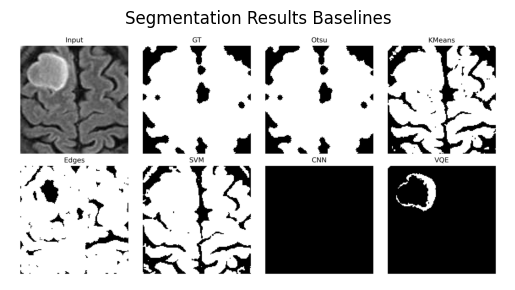

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Example: show the segmentation result
img = Image.open("baseline_out/masks_baselines.png")
plt.imshow(img)
plt.axis('off')
plt.title("Segmentation Results Baselines")
plt.show()

In [ ]:
import pandas as pd

results = pd.read_csv("baseline_out/results_table.csv")
results


,Method,Dice,IoU,Accuracy,AUC
0,Otsu,1.00000,1.000000,1.000000,0.433723
1,KMeans,0.93024,0.869578,0.894653,0.474792
2,Edges,0.85059,0.740023,0.746338,0.514729
3,SVM,0.93252,0.873572,0.894653,0.936172
4,CNN,0.00000,0.000000,0.198486,0.500000
5,VQE,0.08180,0.042644,0.232666,0.433723


In [ ]:
# Example: extract multiple random patches
import numpy as np
from PIL import Image

img = Image.open("G_2_BR_.jpg").convert("L")
img = np.array(img)

PATCH_SIZE = 32
patches = []
for _ in range(10):  # create 10 patches
    x = np.random.randint(0, img.shape[1] - PATCH_SIZE)
    y = np.random.randint(0, img.shape[0] - PATCH_SIZE)
    patch = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
    patches.append(patch)

print(f"Extracted {len(patches)} patches of size {PATCH_SIZE}x{PATCH_SIZE}")


Extracted 10 patches of size 32x32


In [ ]:
!pip install qiskit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install matplotlib


In [ ]:
!pip install pylatexenc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=c8430f4783431d8a6f7103656266c51f1c4a261bbe5192703ffe3ce45f59b34f
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [ ]:
from qiskit import QuantumCircuit

def vqe_ansatz_ring(num_qubits=8, depth=3):
    qc = QuantumCircuit(num_qubits)
    for d in range(depth):
        # Rotations
        for q in range(num_qubits):
            qc.ry(0.5, q)
        # Ring entanglement
        for q in range(num_qubits):
            qc.cx(q, (q+1) % num_qubits)  # last qubit entangles with the first
    qc.measure_all()
    return qc

ansatz = vqe_ansatz_ring()
ansatz.draw('mpl')


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [ ]:
from qiskit_aer import AerSimulator
sim = AerSimulator(method='statevector')
result = sim.run(ansatz).result()
statevector = result.get_statevector()
print("Statevector length:", len(statevector))  # should be 256 for 8 qubits


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
!pip install qiskit matplotlib pylatexenc
!apt-get -qq install -y libfluidsynth1


E: Package 'libfluidsynth1' has no installation candidate


In [ ]:
!pip install pylatexenc

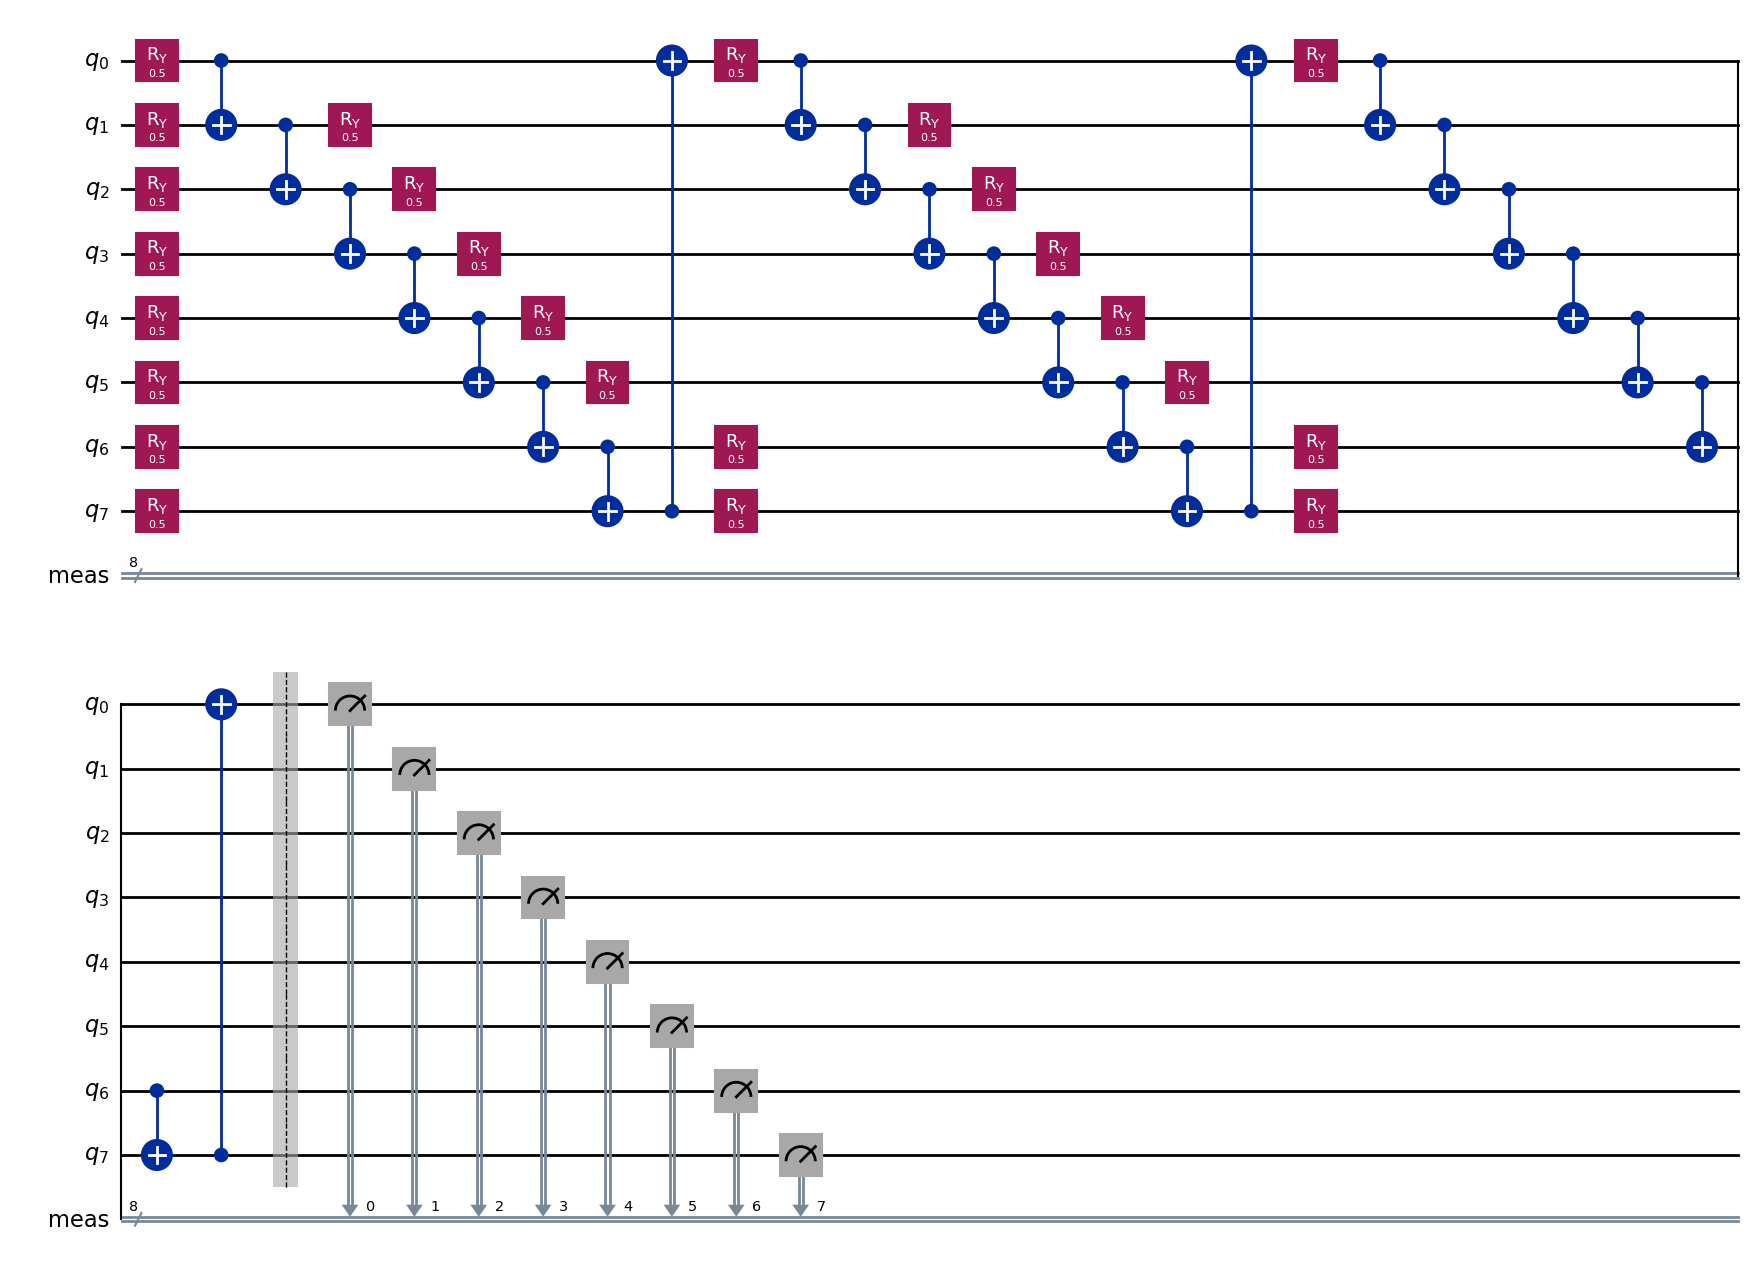

In [ ]:
from qiskit import QuantumCircuit

def vqe_ansatz_ring(num_qubits=8, depth=3):
    qc = QuantumCircuit(num_qubits)
    for d in range(depth):
        for q in range(num_qubits):
            qc.ry(0.5, q)
        for q in range(num_qubits):
            qc.cx(q, (q+1) % num_qubits)  # ring entanglement
    qc.measure_all()
    return qc

ansatz = vqe_ansatz_ring()
# Ensure pylatexenc is installed before drawing
!pip install pylatexenc
ansatz.draw('mpl')  # should now display without error

In [ ]:

!pip install qiskit qiskit-aer



In [ ]:
# Install required packages (run once)
!pip install qiskit qiskit-aer

# -------------------------------
# Imports
# -------------------------------
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# -------------------------------
# Example small image patch (replace with your actual patch)
# -------------------------------
patch = np.random.rand(4,2)  # 4x2 patch
pixels = patch.flatten()

# -------------------------------
# Pad vector to 256 elements for 8 qubits
# -------------------------------
required_length = 2**8  # 256
if len(pixels) < required_length:
    pixels = np.pad(pixels, (0, required_length - len(pixels)), 'constant')

# Normalize vector for amplitude encoding
pixels /= np.linalg.norm(pixels)
print("Pixel vector length after padding:", len(pixels))

# -------------------------------
# Build 8-qubit VQE ansatz with measurements
# -------------------------------
num_qubits = 8
depth = 3

qc = QuantumCircuit(num_qubits)
qc.initialize(pixels, qc.qubits)  # amplitude encode patch

for d in range(depth):
    for q in range(num_qubits):
        qc.ry(0.5, q)
    for q in range(num_qubits):
        qc.cx(q, (q+1) % num_qubits)  # ring entanglement

qc.measure_all()  # measure all qubits

# -------------------------------
# Simulate the circuit
# -------------------------------
sim = AerSimulator()  # QASM simulator
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1024).result()
counts = result.get_counts()

# -------------------------------
# Output measurement counts
# -------------------------------
print("Measurement counts:")
for outcome, count in counts.items():
    print(f"{outcome}: {count}")


Pixel vector length after padding: 256
Measurement counts:
11001011: 1
01100010: 1
01011100: 1
01111111: 2
11110001: 1
11010111: 1
00000101: 5
01101111: 2
00111001: 1
11100001: 1
00001010: 3
01011001: 14
11000001: 1
00101010: 10
10101000: 4
11000110: 1
10011001: 20
10110010: 3
00010101: 4
00100001: 1
01010001: 3
01001111: 2
01100101: 8
00100100: 1
00110100: 9
11111100: 2
11101011: 7
10101110: 10
10001110: 1
01001100: 10
01010100: 23
00011010: 1
10000010: 5
01000001: 5
11010100: 4
10001101: 1
11010010: 34
11001101: 46
11111011: 3
10100010: 1
00001100: 13
10000001: 3
00000011: 6
10011110: 9
01010011: 2
11001110: 5
01010110: 7
01010111: 8
01011111: 4
11001010: 30
10011000: 26
10010110: 1
10000100: 3
11001111: 1
01010101: 153
11111110: 25
11110100: 4
01101000: 6
00101011: 16
00110000: 4
00101101: 3
11011001: 1
10100111: 1
10101011: 13
10010001: 1
10101010: 4
00000010: 3
11001100: 25
01010000: 2
11010101: 1
00000001: 11
01000011: 1
00101001: 2
00110110: 1
01111010: 1
11000010: 2
00011001: 7

In [ ]:
!pip install --upgrade qiskit
